<a href="https://colab.research.google.com/github/ryzhokhina/Tensorflow-Dev-Exam-Preparation/blob/main/Time_series_windowed_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [2]:

!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2023-09-01 20:25:26--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.001s  

2023-09-01 20:25:26 (61.9 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#Load data

In [4]:
data = pd.read_csv('/tmp/daily-min-temperatures.csv')


In [5]:
print(data.shape)
data.head()

(3650, 2)


,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [60]:
# function to plot series

def plot_series(times_steps, data, format="-", start=0, end=None):
    plt.plot(times_steps[start:end],data[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

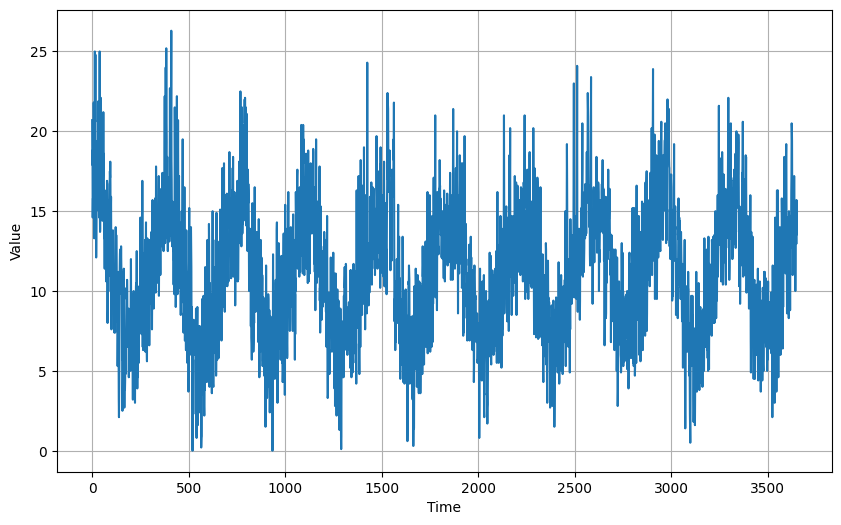

In [42]:
plt.figure(figsize=(10, 6))
plot_series(data.index, data.Temp)

In [9]:
min(data.Date), max(data.Date)

('1981-01-01', '1990-12-31')

In [10]:
10*365 == len(data)

True

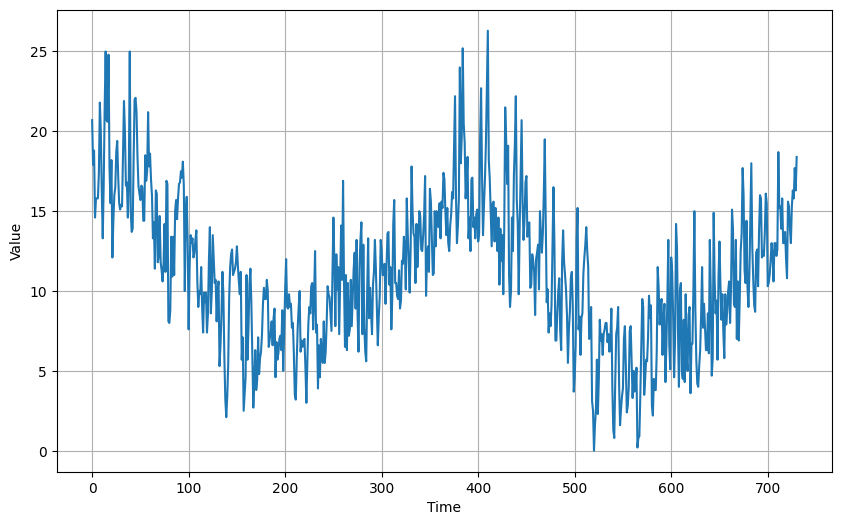

In [43]:
plt.figure(figsize=(10, 6))
plot_series(data.index, data.Temp, format="-", start=0, end=365*2+1)

### Create data set to train model
1. Split to train, test datasets
2. Split into windows dataset

In [13]:
WINDOW_SIZE = 64  # one mounts
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1000

In [14]:
# split data to train and test sets

n_val_data=int(len(data)*0.2)
n_train_data=len(data)-n_val_data

train_data = data[:n_train_data]
val_data = data[n_train_data:]

print(train_data.shape)
print(val_data.shape)


(2920, 2)
(730, 2)


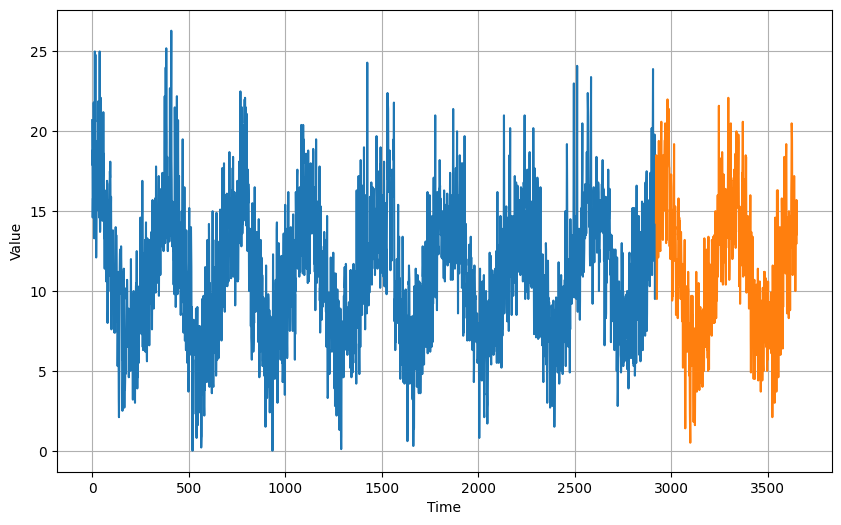

In [45]:
plt.figure(figsize=(10, 6))
plot_series(train_data.index, train_data.Temp, format="-")
plot_series(val_data.index, val_data.Temp, format="*")

In [46]:
def windowed_dataset(series, window_size, batch_size, shuffled = False, shuffle_buffer = None):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda window: window.batch(window_size + 1))
  if shuffled:
    ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda window: (window[:-1], window[-1]))
  return ds.batch(batch_size).prefetch(1)


In [47]:
train_ds = windowed_dataset(train_data.Temp, WINDOW_SIZE, BATCH_SIZE, True, SHUFFLE_BUFFER_SIZE)
test_ds = windowed_dataset(val_data.Temp, WINDOW_SIZE, BATCH_SIZE)


## Create model

In [48]:
def create_model(optimizer = 'adam'):
  model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                        strides=1, padding="causal",
                        activation="relu",
                        input_shape=[WINDOW_SIZE, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
  ])
  model.compile(loss=tf.keras.losses.Huber(),
                optimizer=optimizer,
                metrics=["mae"])
  return model

In [22]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)

model = create_model(optimizer)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 64, 32)            192       
                                                                 
 lstm (LSTM)                 (None, 64, 64)            24832     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 30)                1950      
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
 lambda (Lambda)             (None, 1)                 0

In [23]:
learning_rate_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

history = model.fit(train_ds, epochs=100, verbose=1, validation_data=test_ds, callbacks=[learning_rate_callback])

Epoch 1/100
23/23 [==============================] - 8s 100ms/step - loss: 143.0897 - mae: 143.5897 - val_loss: 135.3356 - val_mae: 135.8356 - lr: 1.0000e-08
Epoch 2/100
23/23 [==============================] - 1s 34ms/step - loss: 127.1450 - mae: 127.6450 - val_loss: 118.2221 - val_mae: 118.7221 - lr: 1.1220e-08
Epoch 3/100
23/23 [==============================] - 1s 30ms/step - loss: 110.5164 - mae: 111.0164 - val_loss: 101.4228 - val_mae: 101.9228 - lr: 1.2589e-08
Epoch 4/100
23/23 [==============================] - 1s 30ms/step - loss: 93.3957 - mae: 93.8957 - val_loss: 84.0926 - val_mae: 84.5926 - lr: 1.4125e-08
Epoch 5/100
23/23 [==============================] - 1s 31ms/step - loss: 76.3862 - mae: 76.8862 - val_loss: 66.8287 - val_mae: 67.3287 - lr: 1.5849e-08
Epoch 6/100
23/23 [==============================] - 1s 32ms/step - loss: 58.2947 - mae: 58.7947 - val_loss: 47.1268 - val_mae: 47.6262 - lr: 1.7783e-08
Epoch 7/100
23/23 [==============================] - 1s 32ms/step - l

In [24]:
history.history.keys()


dict_keys(['loss', 'mae', 'val_loss', 'val_mae', 'lr'])

Text(0.5, 0, 'Learning rate')

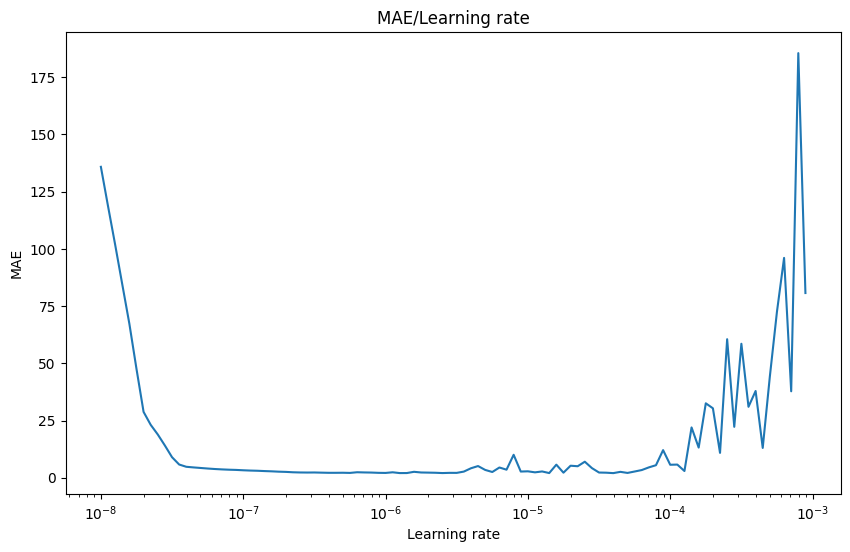

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['lr'], history.history['val_mae'])
plt.xscale('log')
plt.title('MAE/Learning rate')
plt.ylabel('MAE')
plt.xlabel('Learning rate')


In [49]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.h5',
    monitor='mae',
    verbose=0,
    save_best_only=True)

model = create_model(optimizer)
model.fit(train_ds, epochs=100, verbose=1, callbacks=[model_checkpoint])

Epoch 1/100
23/23 [==============================] - 4s 23ms/step - loss: 53.9162 - mae: 54.4141
Epoch 2/100
23/23 [==============================] - 2s 72ms/step - loss: 8.6621 - mae: 9.1517
Epoch 3/100
23/23 [==============================] - 1s 27ms/step - loss: 2.6263 - mae: 3.0918
Epoch 4/100
23/23 [==============================] - 1s 24ms/step - loss: 1.8082 - mae: 2.2605
Epoch 5/100
23/23 [==============================] - 1s 25ms/step - loss: 1.7657 - mae: 2.2162
Epoch 6/100
23/23 [==============================] - 1s 27ms/step - loss: 1.7502 - mae: 2.1997
Epoch 7/100
23/23 [==============================] - 1s 25ms/step - loss: 1.7038 - mae: 2.1520
Epoch 8/100
23/23 [==============================] - 1s 23ms/step - loss: 1.7081 - mae: 2.1553
Epoch 9/100
23/23 [==============================] - 1s 24ms/step - loss: 1.7023 - mae: 2.1514
Epoch 10/100
23/23 [==============================] - 1s 26ms/step - loss: 1.6965 - mae: 2.1466
Epoch 11/100
23/23 [===========================

In [50]:
# load best model

best_model = tf.keras.models.load_model('best_model.h5')

best_model.evaluate(test_ds)

6/6 [==============================] - 1s 19ms/step - loss: 1.3846 - mae: 1.8272


[1.3846477270126343, 1.8272438049316406]

#Forecast using model

In [51]:
test_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [52]:
pr = best_model.predict(test_ds)

6/6 [==============================] - 1s 17ms/step


In [53]:
pr.shape

(666, 1)

In [34]:
pr = pr.reshape(-1)
pr.shape

(666,)

In [54]:
val_data.shape

(730, 2)

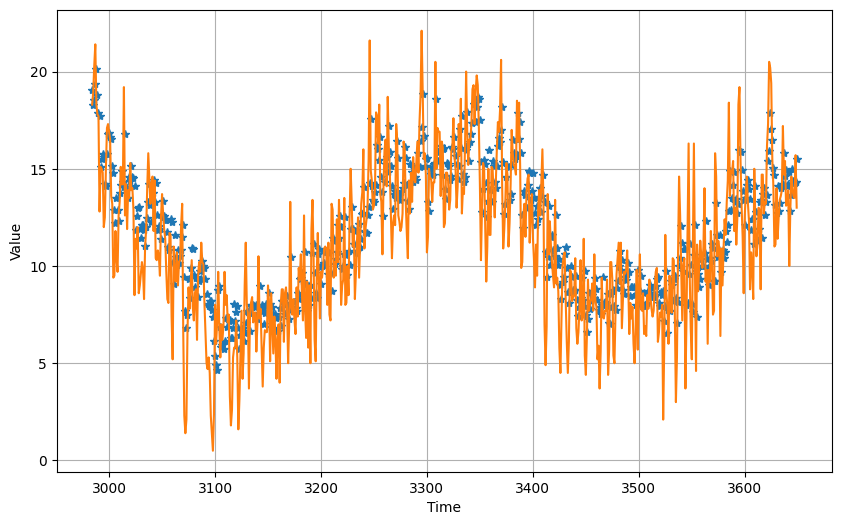

In [61]:
plt.figure(figsize=(10, 6))
plot_series(val_data[WINDOW_SIZE:].index, pr, format="*")
plot_series(val_data.index, val_data.Temp, format="-", start = WINDOW_SIZE)

In [57]:
730-666

64

In [124]:
val_data.head()

,Date,Temp
2920,1989-01-01,14.3
2921,1989-01-02,17.4
2922,1989-01-03,18.5
2923,1989-01-04,16.8
2924,1989-01-05,11.5
